JESÚS TOMÁS ALMANSA FERNÁNDEZ


JAVIER LUENGO GONZÁLEZ


MIGUEL ÁNGEL DEL CERRO RECUERO


FRANCISCO MANUEL OLMEDO BUENO

|                                  | Sí  | No  | A veces |
|----------------------------------|-----|-----|---------|
| Todos los miembros se han integrado al trabajo del grupo |  X  |     |         |
| Todos los miembros participan activamente                |  X  |     |         |
| Todos los miembros respetan otras ideas aportadas        |  X  |     |         |
| Todos los miembros participan en la elaboración del informe |  X  |     |         |
| Me he preocupado por realizar un trabajo cooperativo con mis compañeros |  X  |     |         |
| Señala si consideras que algún aspecto del trabajo en grupo no ha sido adecuado |     |     |         |


In [2]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization

In [3]:
# # Primero, bajamos los datos de entrenamiento
# keras.utils.get_file(fname="simpsons_train.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# # Descomprimimos el archivo
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# # Hacemos lo mismo con los datos de test
# keras.utils.get_file(fname="simpsons_test.tar.gz", 
#                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
# !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [4]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.85
        if(logs.get('val_accuracy')> accuracy):
            print("\nAlcanzado el {}% de precisión, se cancela el entrenamiento!!".format(accuracy))
            self.model.stop_training = True

In [6]:
callback = myCallback()

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [9]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.

DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

# DATASET_TRAIN_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons"
# DATASET_TEST_PATH_COLAB = "/home/jesus/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

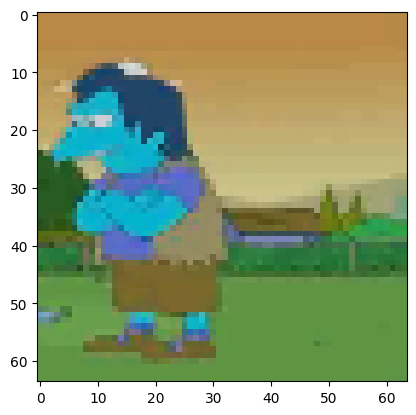

In [11]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro


Normalizamos los valores de los conjuntos de datos de entrenamiento y test

In [12]:
X_scaled = X / 255.0
X_test_scaled = X_test / 255.0
y = y.astype('int')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [14]:
y_train = to_categorical(y_train, num_classes=18)
y_valid = to_categorical(y_valid, num_classes=18)
y_test = to_categorical(y_test, num_classes=18)

## Análisis de los datos a utilizar.

#### Observamos las dimensiones de los conjuntos de datos

In [15]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_valid: {X_valid.shape}')
print(f'Shape y_valid: {y_valid.shape}')

Shape X_train: (15193, 64, 64, 3)
Shape y_train: (15193, 18)
Shape X_valid: (3799, 64, 64, 3)
Shape y_valid: (3799, 18)


#### Podemos desglosar esta información de la siguiente manera
+ 15193 es el número de instancias que tenemos en la variable X_train
+ 64 es el número de píxeles que tiene cada imagen, siendo de 64x64
+ 3 es el número de canales de colores que contiene cada imagen

Para los datos del target, es unidimensional

#### Definimos el early stopping para cortar el entrenamiento cuando el modelo deje de mejorar

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

#### Creamos varias redes neuronales que aprendan a diferenciar a los personajesde Los Simpson

In [17]:
def pintar_grafica():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

### Red Neuronal Convolucional - CNN

Epoch 1/40
475/475 - 18s - loss: 1.6531 - accuracy: 0.5329 - val_loss: 1.4818 - val_accuracy: 0.5523 - 18s/epoch - 37ms/step
Epoch 2/40
475/475 - 4s - loss: 0.7837 - accuracy: 0.7627 - val_loss: 0.8932 - val_accuracy: 0.7405 - 4s/epoch - 9ms/step
Epoch 3/40
475/475 - 5s - loss: 0.4275 - accuracy: 0.8688 - val_loss: 0.7230 - val_accuracy: 0.7968 - 5s/epoch - 10ms/step
Epoch 4/40
475/475 - 5s - loss: 0.2026 - accuracy: 0.9416 - val_loss: 0.7084 - val_accuracy: 0.8115 - 5s/epoch - 11ms/step
Epoch 5/40
475/475 - 4s - loss: 0.0950 - accuracy: 0.9760 - val_loss: 0.6974 - val_accuracy: 0.8210 - 4s/epoch - 8ms/step
Epoch 6/40
475/475 - 4s - loss: 0.0520 - accuracy: 0.9882 - val_loss: 0.7313 - val_accuracy: 0.8181 - 4s/epoch - 9ms/step
Epoch 7/40
475/475 - 4s - loss: 0.0383 - accuracy: 0.9903 - val_loss: 0.6846 - val_accuracy: 0.8342 - 4s/epoch - 9ms/step
Epoch 8/40
475/475 - 4s - loss: 0.0229 - accuracy: 0.9954 - val_loss: 0.6894 - val_accuracy: 0.8344 - 4s/epoch - 9ms/step
Epoch 9/40
475/475 

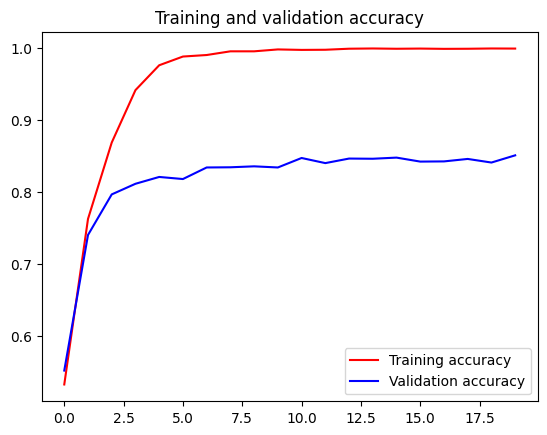

<Figure size 640x480 with 0 Axes>

28/28 - 0s - loss: 0.1318 - accuracy: 0.9685 - 230ms/epoch - 8ms/step
El resultado del modelo para el conjunto de test es: [0.13178664445877075, 0.968539297580719]


In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    batch_size = 32,
                    callbacks=[early_stopping, callback])

pintar_grafica()

print("El resultado del modelo para el conjunto de test es: {}".format(model.evaluate(X_test_scaled, y_test, verbose=2)))


# Modelo CNN definitivo

Epoch 1/40
475/475 - 7s - loss: 1.7792 - accuracy: 0.4738 - val_loss: 1.5775 - val_accuracy: 0.5159 - 7s/epoch - 16ms/step
Epoch 2/40
475/475 - 4s - loss: 1.0270 - accuracy: 0.6958 - val_loss: 1.1915 - val_accuracy: 0.6423 - 4s/epoch - 8ms/step
Epoch 3/40
475/475 - 4s - loss: 0.6753 - accuracy: 0.7949 - val_loss: 0.7937 - val_accuracy: 0.7726 - 4s/epoch - 7ms/step
Epoch 4/40
475/475 - 3s - loss: 0.4402 - accuracy: 0.8671 - val_loss: 0.7397 - val_accuracy: 0.7902 - 3s/epoch - 7ms/step
Epoch 5/40
475/475 - 4s - loss: 0.2825 - accuracy: 0.9131 - val_loss: 0.8116 - val_accuracy: 0.7802 - 4s/epoch - 8ms/step
Epoch 6/40
475/475 - 4s - loss: 0.1893 - accuracy: 0.9435 - val_loss: 0.7202 - val_accuracy: 0.8155 - 4s/epoch - 8ms/step
Epoch 7/40
475/475 - 3s - loss: 0.1271 - accuracy: 0.9620 - val_loss: 0.7141 - val_accuracy: 0.8231 - 3s/epoch - 7ms/step
Epoch 8/40
475/475 - 4s - loss: 0.0799 - accuracy: 0.9774 - val_loss: 0.7086 - val_accuracy: 0.8379 - 4s/epoch - 8ms/step
Epoch 9/40
475/475 - 4s

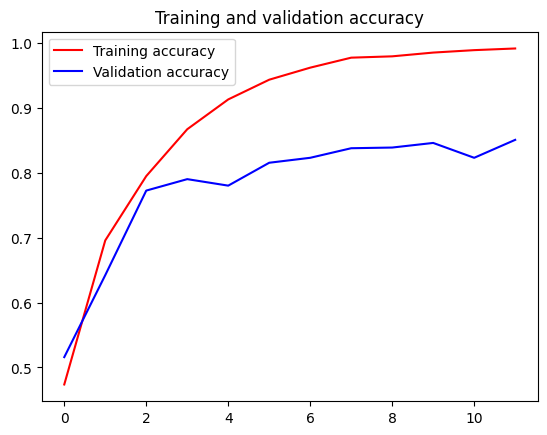

<Figure size 640x480 with 0 Axes>

28/28 - 0s - loss: 0.2144 - accuracy: 0.9584 - 156ms/epoch - 6ms/step
El resultado del modelo para el conjunto de test es: [0.21442802250385284, 0.9584269523620605]


In [28]:
model = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(18, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    batch_size = 32,
                    callbacks=[early_stopping, callback])

pintar_grafica()

print("El resultado del modelo para el conjunto de test es: {}".format(model.evaluate(X_test_scaled, y_test, verbose=2)))

#### Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?

28/28 [==============================] - 0s 5ms/step


<Axes: >

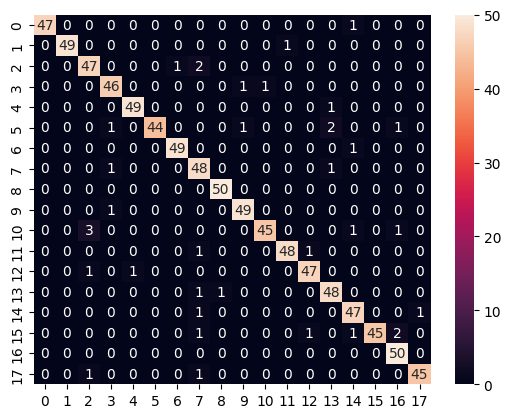

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtén las predicciones del modelo
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Crea la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Visualiza la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d')

#### Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados

In [43]:
correct_predictions = np.sum(y_pred_classes == y_test_classes)

print(f'Correct predictions: {correct_predictions} out of {len(y_test_classes)}')

Correct predictions: 853 out of 890


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calcula precisión, recall y F1-score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}')

Precision: 0.9600299109299779, Recall: 0.9584269662921349, F1-score: 0.9585409630442361


In [47]:
from sklearn.metrics import classification_report
classificationreport = classification_report(y_test_classes, y_pred_classes)
print(classificationreport)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       1.00      0.98      0.99        50
           2       0.90      0.94      0.92        50
           3       0.94      0.96      0.95        48
           4       0.98      0.98      0.98        50
           5       1.00      0.90      0.95        49
           6       0.98      0.98      0.98        50
           7       0.87      0.96      0.91        50
           8       0.98      1.00      0.99        50
           9       0.96      0.98      0.97        50
          10       0.98      0.90      0.94        50
          11       0.98      0.96      0.97        50
          12       0.96      0.96      0.96        49
          13       0.92      0.96      0.94        50
          14       0.92      0.96      0.94        49
          15       1.00      0.90      0.95        50
          16       0.93      1.00      0.96        50
          17       0.98    

Podemos observar de un simple vistazo que el valor más pequeño para el f1-score es el número 7. Comprobamos en el diccionario de personajes cuál de ellos es el que peor reconoce.

In [51]:
MAP_CHARACTERS[7]

'homer_simpson'

## Comparación de modelos CNNs con un modelo de Fully Connected para este problema.

### Red Neuronal Artificial - ANN

Epoch 1/40
475/475 - 5s - loss: 2.5628 - accuracy: 0.2273 - val_loss: 2.1830 - val_accuracy: 0.3280 - 5s/epoch - 10ms/step
Epoch 2/40
475/475 - 2s - loss: 2.1406 - accuracy: 0.3554 - val_loss: 2.0257 - val_accuracy: 0.3875 - 2s/epoch - 4ms/step
Epoch 3/40
475/475 - 3s - loss: 1.9929 - accuracy: 0.3963 - val_loss: 1.9882 - val_accuracy: 0.4072 - 3s/epoch - 5ms/step
Epoch 4/40
475/475 - 2s - loss: 1.8696 - accuracy: 0.4370 - val_loss: 1.9610 - val_accuracy: 0.4204 - 2s/epoch - 5ms/step
Epoch 5/40
475/475 - 2s - loss: 1.7630 - accuracy: 0.4683 - val_loss: 1.8409 - val_accuracy: 0.4441 - 2s/epoch - 4ms/step
Epoch 6/40
475/475 - 2s - loss: 1.6664 - accuracy: 0.4990 - val_loss: 1.7091 - val_accuracy: 0.4862 - 2s/epoch - 4ms/step
Epoch 7/40
475/475 - 2s - loss: 1.5704 - accuracy: 0.5231 - val_loss: 1.6618 - val_accuracy: 0.5064 - 2s/epoch - 4ms/step
Epoch 8/40
475/475 - 2s - loss: 1.4848 - accuracy: 0.5483 - val_loss: 1.7061 - val_accuracy: 0.4870 - 2s/epoch - 4ms/step
Epoch 9/40
475/475 - 3s

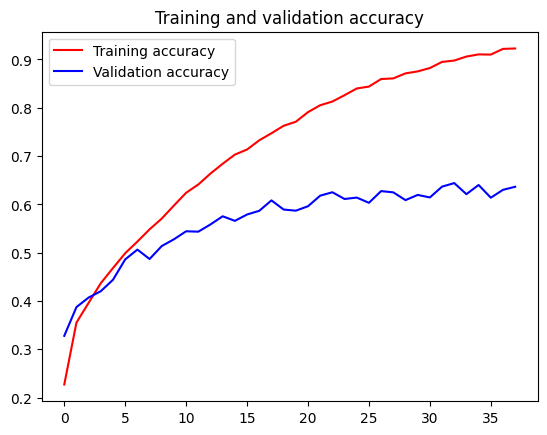

<Figure size 640x480 with 0 Axes>

28/28 - 0s - loss: 0.5886 - accuracy: 0.8629 - 85ms/epoch - 3ms/step
El resultado del modelo para el conjunto de test es: [0.5886013507843018, 0.8629213571548462]


In [65]:
#definicion de la arquitectura del modelo secuencial. 
#Comenzamos con una capa convolucional con 32 filtros de tamaño (3, 3) y función de activación ReLU, seguida de una capa de pooling con tamaño de ventana (2, 2). 
#Luego agreamos dos capas convolucionales más con más filtros y capas de pooling correspondientes. 
#A continuación, se aplanan los mapas de características resultantes y se agrega una capa de dropout para evitar el sobreajuste. 
#Luego se agregan dos capas densamente conectadas, con la última capa utilizando una función de activación softmax para la clasificación de las 18 clases
# Por ultimo el resumen del modelo, que incluye información. 

model = Sequential([

    Flatten(input_shape=(64, 64, 3)),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(18, activation='softmax')

])

model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    batch_size = 32,
                    callbacks=[early_stopping, callback])

pintar_grafica()

print("El resultado del modelo para el conjunto de test es: {}".format(model.evaluate(X_test_scaled, y_test, verbose=2)))

A la hora de trabajar con una fully connected podemos observar como el modelo tarda mucho más en converger ya que tiene que recorrer todos los píxeles de uno en uno, siendo mucho más costoso computacionalmente para el modelo. No identifica tan bien las imágenes porque al entrar un vector flatten se pierde la relación espacial que existe entre los píxeles de las imágenes. 

## Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.

In [16]:
model = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(18, activation='softmax')
])

#### Pruebas CNN BATCH SIZE [32,64,128,256,512]





-------------------------------------
-------------------------------------
Prueba con Batch Size: 32
Epoch 25: early stopping


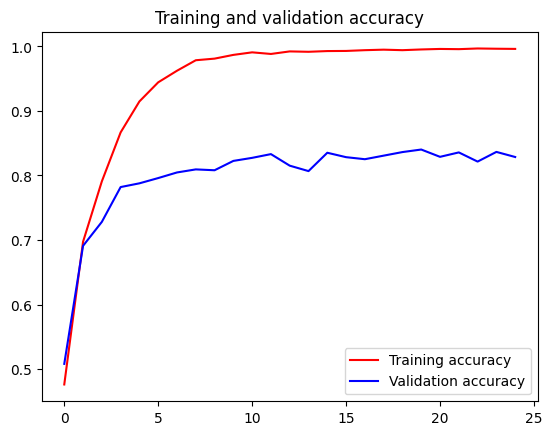

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 0s 4ms/step - loss: 0.9556 - accuracy: 0.8286


Métricas con dataset de test:
28/28 [==============================] - 0s 7ms/step - loss: 0.2548 - accuracy: 0.9573




-------------------------------------
-------------------------------------
Prueba con Batch Size: 64
Epoch 6: early stopping


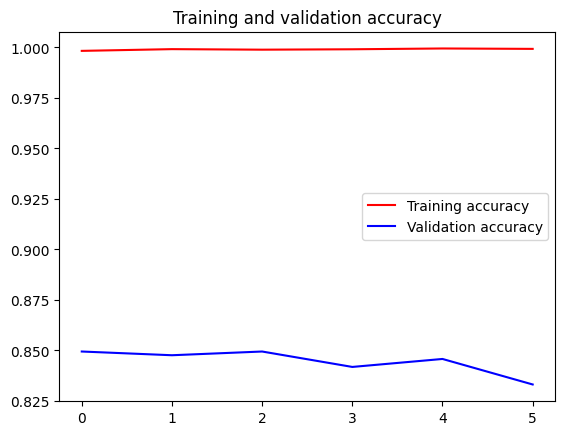

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 5ms/step - loss: 0.9545 - accuracy: 0.8331


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.2405 - accuracy: 0.9551




-------------------------------------
-------------------------------------
Prueba con Batch Size: 128

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


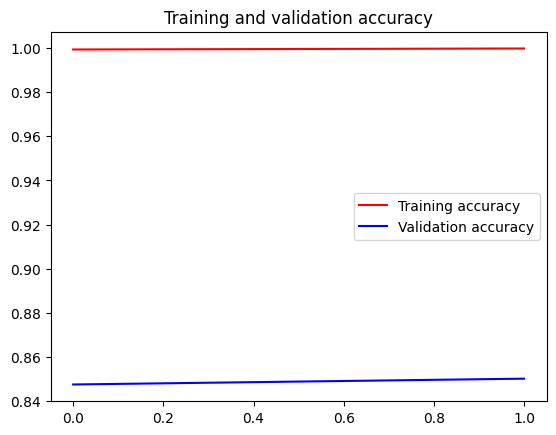

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 4ms/step - loss: 0.8753 - accuracy: 0.8502


Métricas con dataset de test:
28/28 [==============================] - 0s 4ms/step - loss: 0.2104 - accuracy: 0.9652




-------------------------------------
-------------------------------------
Prueba con Batch Size: 256

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


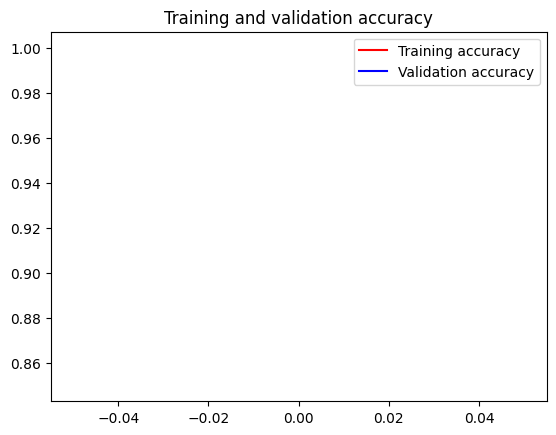

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 4ms/step - loss: 0.8683 - accuracy: 0.8502


Métricas con dataset de test:
28/28 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9629




-------------------------------------
-------------------------------------
Prueba con Batch Size: 512

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


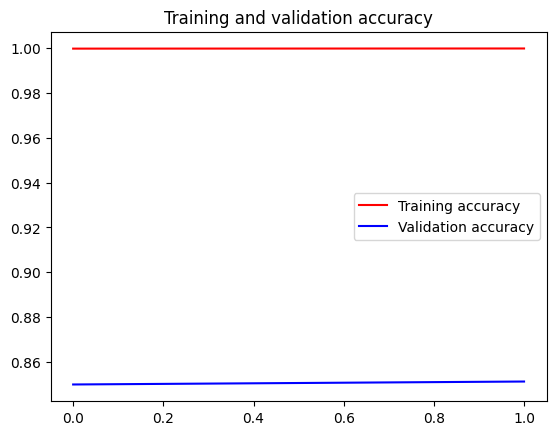

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 4ms/step - loss: 0.8748 - accuracy: 0.8513


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.2217 - accuracy: 0.9640




In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

for i in [32,64,128,256,512]:
  print('\n')
  print('-------------------------------------')
  print('-------------------------------------')
  print(f'Prueba con Batch Size: {i}')

  history = model.fit(X_train, y_train,
          epochs=200,
          validation_data=(X_valid, y_valid),
          verbose=0, 
          batch_size = i,
          callbacks=[early_stopping, callback])
  


  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

  # Evaluar el modelo en el conjunto de datos de prueba
  print(f'\n')
  print(f'Métricas con dataset de validación:')

  valid_loss, valid_acc = model.evaluate(X_valid, y_valid)

  print(f'\n')
  print(f'Métricas con dataset de test:')

  test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

  print(f'\n')

Los resultados aumentando el batch size son similares, viéndose una mejora ínfima pero aumentando el uso de memoria ram que necesitamos, complicando el cómputo del mismo. Al ser pequeño el conjunto de datos aprende rápido cuando el batch size es mayor.

## **PRUEBAS CNN OPTIMIZER ["sgd", "rmsprop", "adam", "adagrad", "adadelta", "adamax", "nadam", "ftrl"]** 



-------------------------------------
-------------------------------------


 Pruebas con optimizador: sgd
Epoch 22: early stopping


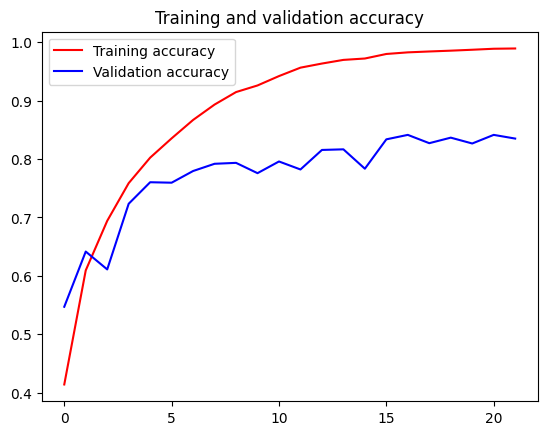

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 6ms/step - loss: 0.8183 - accuracy: 0.8350


Métricas con dataset de test:
28/28 [==============================] - 0s 11ms/step - loss: 0.2041 - accuracy: 0.9562




-------------------------------------
-------------------------------------


 Pruebas con optimizador: rmsprop
Epoch 15: early stopping


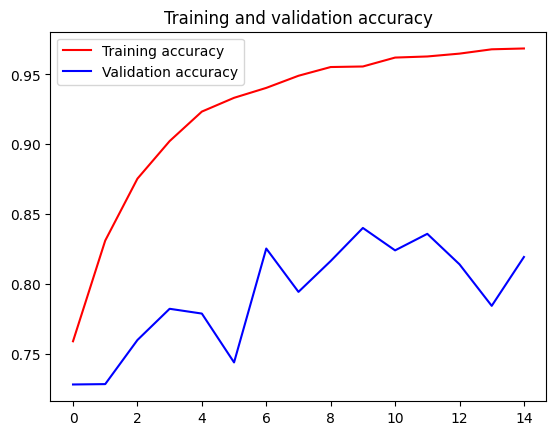

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 5ms/step - loss: 2.0312 - accuracy: 0.8192


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 1.0003 - accuracy: 0.8978




-------------------------------------
-------------------------------------


 Pruebas con optimizador: adam
Epoch 10: early stopping


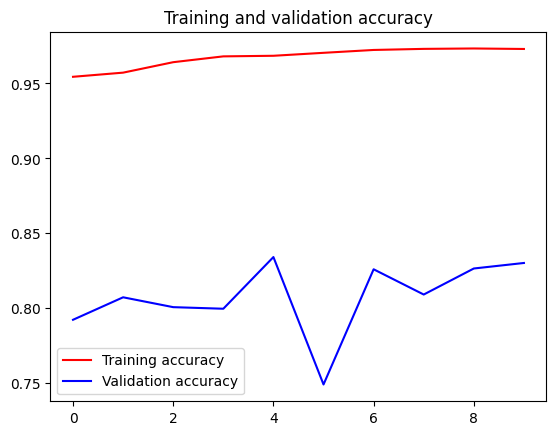

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 6ms/step - loss: 1.0873 - accuracy: 0.8302


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.3014 - accuracy: 0.9449




-------------------------------------
-------------------------------------


 Pruebas con optimizador: adagrad

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


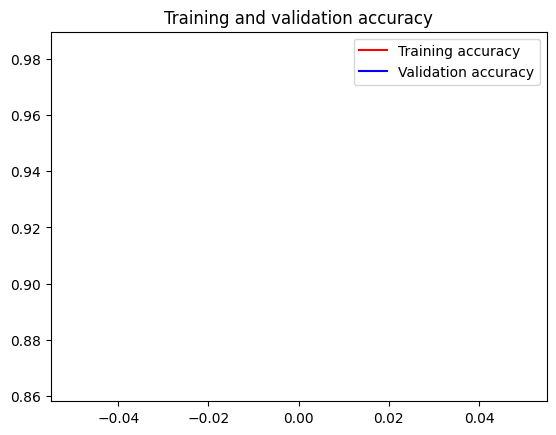

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 5ms/step - loss: 0.8924 - accuracy: 0.8642


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.2462 - accuracy: 0.9697




-------------------------------------
-------------------------------------


 Pruebas con optimizador: adadelta

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


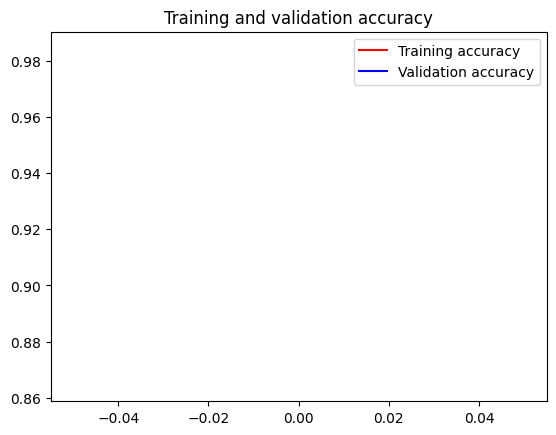

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 5ms/step - loss: 0.8961 - accuracy: 0.8647


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.2437 - accuracy: 0.9719




-------------------------------------
-------------------------------------


 Pruebas con optimizador: adamax

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


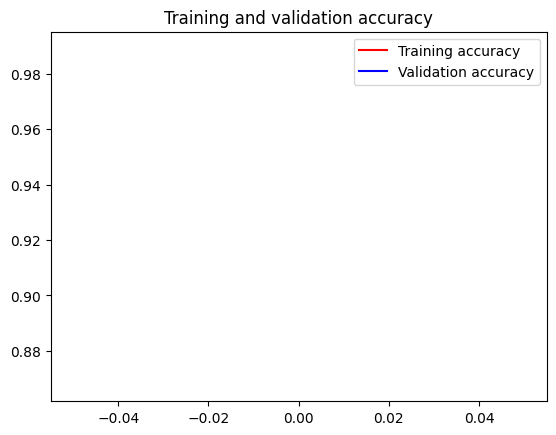

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 4ms/step - loss: 0.9446 - accuracy: 0.8679


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.2446 - accuracy: 0.9730




-------------------------------------
-------------------------------------


 Pruebas con optimizador: nadam

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!


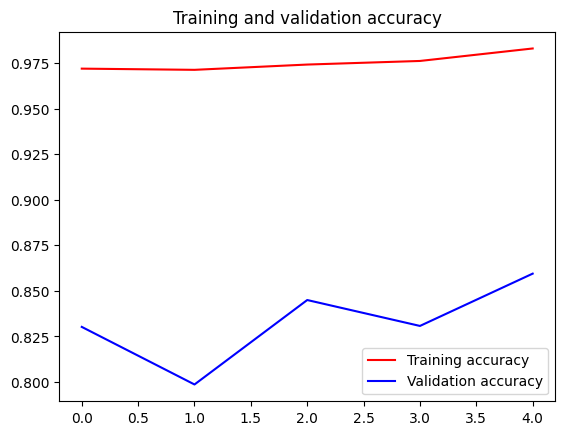

<Figure size 640x480 with 0 Axes>



Métricas con dataset de validación:
119/119 [==============================] - 1s 4ms/step - loss: 1.2270 - accuracy: 0.8594


Métricas con dataset de test:
28/28 [==============================] - 0s 5ms/step - loss: 0.3611 - accuracy: 0.9539




-------------------------------------
-------------------------------------


 Pruebas con optimizador: ftrl


In [ ]:
# Lista de optimizadores que se van a utilizar durante las pruebas
lista_optimizadores = ["sgd", "rmsprop", "adam", "adagrad", "adadelta", "adamax", "nadam", "ftrl"]

for optimizador in lista_optimizadores:
  print('\n')
  print('-------------------------------------')
  print('-------------------------------------')
  print('\n')
  print(f' Pruebas con optimizador: {optimizador}')


  model.compile(loss = 'categorical_crossentropy', optimizer=optimizador, metrics=['accuracy'])

  history = model.fit(X_train, y_train,
          epochs=200,
          validation_data=(X_valid, y_valid),
          verbose=0, 
          batch_size = 32,
          callbacks=[early_stopping, callback])

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

  # Evaluar el modelo en el conjunto de datos de prueba
  print(f'\n')
  print(f'Métricas con dataset de validación:')

  valid_loss, valid_acc = model.evaluate(X_valid, y_valid)

  print(f'\n')
  print(f'Métricas con dataset de test:')

  test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

  print(f'\n')

El mejor optimizador ha sido Adamax

### Data augmentation

Epoch 1/40

Alcanzado el 0.85% de precisión, se cancela el entrenamiento!!
474/474 - 24s - loss: 0.3596 - accuracy: 0.8899 - val_loss: 0.4617 - val_accuracy: 0.8779 - 24s/epoch - 50ms/step


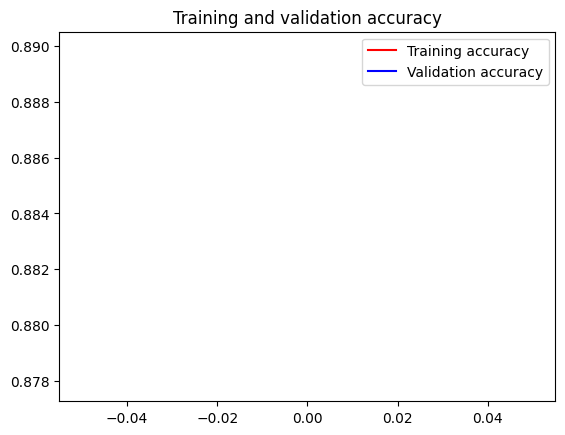

<Figure size 640x480 with 0 Axes>

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=40, validation_data=(X_valid, y_valid),
                    verbose=2,
                    callbacks=[early_stopping, callback])

pintar_grafica()

In [21]:
model.evaluate(X_test_scaled, y_test)

28/28 [==============================] - 0s 6ms/step - loss: 0.0941 - accuracy: 0.9697


[0.09406513720750809, 0.9696629047393799]

Tener más imágenes permite al modelo generalizar mejor en un número menor de epochs